In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adam
import keras_tuner as kt

2024-03-09 18:45:38.807388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 18:45:39.575696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
labels_df = pd.read_csv('aptos-2015-training.csv')
image_paths = labels_df['image'].apply(lambda x: os.path.join('train_resized', x + '.jpg')).tolist()
labels = labels_df['level'].tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'aptos-2015-training.csv'

### Class Weight Adjustment

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# labels = np.array(labels)  # Assuming 'labels' is your list/array of labels

# # Find unique classes and their distributions
# unique_classes = np.unique(labels)
# class_distribution = [sum(labels == i) for i in unique_classes]

# # Calculate class weights
# weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
# class_weights = {class_label: weight for class_label, weight in zip(unique_classes, weights)}

# print("Class weights: ", class_weights)


In [ ]:
# # Original class weights
# class_weights = {0: 0.27218907400232467, 1: 2.875644699140401, 2: 1.3275132275132275, 3: 8.047193585337915, 4: 9.922598870056497}

# # Determine a scaling factor
# scaling_factor = 0.5  # Example scaling factor, adjust based on your needs

# # Scale the class weights
# moderate_class_weights = {k: v ** scaling_factor for k, v in class_weights.items()}

# # Assuming class_datasets are ordered by class labels
# class_labels = sorted(moderate_class_weights.keys())
# moderate_class_weights_list = [moderate_class_weights[label] for label in class_labels]

# print("Moderate class weights: ", moderate_class_weights)

In [ ]:
# # Sum of original class weights
# weights_sum = sum(class_weights.values())

# # Number of classes
# num_classes = len(class_weights)

# # Normalize class weights to sum up to num_classes
# normalized_class_weights = {k: (v / weights_sum) * num_classes for k, v in class_weights.items()}

# # Assuming class_datasets are ordered by class labels
# class_labels = sorted(moderate_class_weights.keys())
# normalized_class_weights_list = [normalized_class_weights[label] for label in class_labels]

# print("Normalized class weights: ", normalized_class_weights)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming image_paths and labels are your full dataset
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # If using ResNet50V2's preprocess_input, remove the manual rescaling above
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

In [ ]:
# Your moderate class weights
class_weights = {0: 0.27218907400232467, 1: 2.875644699140401, 2: 1.3275132275132275, 3: 8.047193585337915, 4: 9.922598870056497}
scaling_factor = 0.5  # Adjust based on your needs
moderate_class_weights = {k: v ** scaling_factor for k, v in class_weights.items()}

# Calculate the maximum weight to determine the oversampling ratio
max_weight = max(moderate_class_weights.values())

# Calculate oversampling ratios
oversampling_ratios = {k: max_weight / v for k, v in moderate_class_weights.items()}


In [ ]:
import random
# Placeholder for the new oversampled dataset
oversampled_image_paths = []
oversampled_labels = []

# Perform oversampling
for label, path in zip(train_labels, train_image_paths):
    num_samples = int(round(oversampling_ratios[label]))  # Determine the number of times to replicate each sample
    oversampled_image_paths.extend([path] * num_samples)
    oversampled_labels.extend([label] * num_samples)

# Shuffle the oversampled dataset to ensure mixed classes
oversampled_dataset = list(zip(oversampled_image_paths, oversampled_labels))
random.shuffle(oversampled_dataset)  # Ensure you've imported random

# Unzip the shuffled dataset back into image paths and labels
oversampled_image_paths, oversampled_labels = zip(*oversampled_dataset)


In [ ]:
import tensorflow as tf
import random

def create_dataset(image_paths, labels, batch_size, is_training=True):
    # Convert lists to TensorFlow tensors
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)
    
    # Create a TensorFlow dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map the preprocessing function with parallel processing
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        # Shuffle the dataset using the buffer size and enable reshuffling each iteration
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch the dataset and prefetch to improve performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Assuming BUFFER_SIZE, BATCH_SIZE, and mirrored_strategy are defined
BUFFER_SIZE = 1000
BATCH_SIZE_PER_REPLICA = 200
mirrored_strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

# Use the oversampled dataset for training
train_ds = create_dataset(list(oversampled_image_paths), list(oversampled_labels), BATCH_SIZE, is_training=True)
val_ds = create_dataset(list(val_image_paths), list(val_labels), BATCH_SIZE, is_training=False)  # Validation dataset doesn't necessarily need oversampling


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-03-06 12:50:39.183377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 12:50:39.184068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 12:50:39.184536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

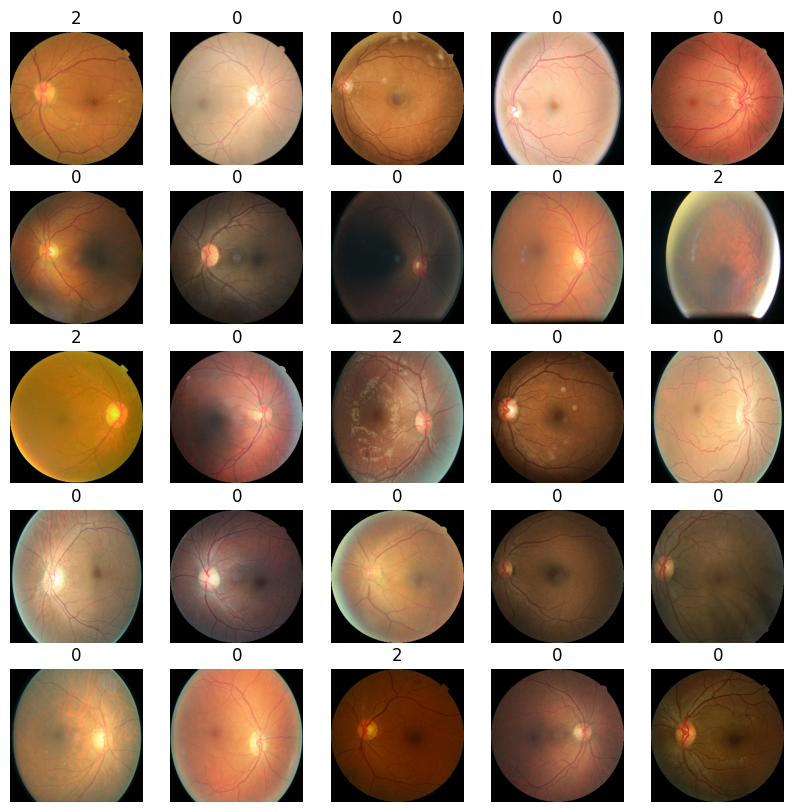

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(min(len(image_batch), 25)):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n] / 2 + 0.5)  # Rescale back to [0,1] if preprocessing included normalization
        plt.title(label_batch[n].numpy())
        plt.axis('off')

# Taking one batch from the training dataset
for image_batch, label_batch in train_ds.take(1):
    show_batch(image_batch.numpy(), label_batch)

# Note: This visualization step assumes that your preprocessing function normalizes the images in a way that can be reversed for visualization.


In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    def build_model(hp):
        model = keras.Sequential()
        
        # Data Augmentation with tunable parameters
        model.add(layers.experimental.preprocessing.RandomFlip(
            mode=hp.Choice('flip_mode', values=['horizontal', 'vertical', 'horizontal_and_vertical']),
            input_shape=(224, 224, 3)))
        model.add(layers.experimental.preprocessing.RandomRotation(
            factor=hp.Float('rotation_factor', min_value=0.0, max_value=0.1))),
        model.add(layers.experimental.preprocessing.RandomZoom(
            height_factor=hp.Float('height_factor', min_value=-0.50, max_value=0.05),
            width_factor=hp.Float('width_factor', min_value=-0.50, max_value=0.05)))
        model.add(layers.experimental.preprocessing.RandomContrast(
            factor=hp.Float('contrast_factor', min_value=0.005, max_value=0.3)))
    

        
        # Base model without top layers
        base_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        base_model.trainable = False
        model.add(base_model)
        
        # Custom layers atop the pre-trained model
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu')),
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))),
        model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu')),
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))),
        model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu')),
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))),
        model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of units based on your number of classes
        
        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 1e-4])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        
        return model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     distribution_strategy=mirrored_strategy,
                     max_epochs=33,
                     factor=3,
                     directory='6_ft_5_Distributed_Omicron_Distributed',
                     project_name='6_fine_tuning')

In [ ]:
# Start the search
tuner.search(train_ds, epochs=33, validation_data=val_ds)  # Ensure train_ds and val_ds are defined and preprocessed

Trial 48 Complete [00h 06m 40s]
val_accuracy: 0.7368345856666565

Best val_accuracy So Far: 0.7392541766166687
Total elapsed time: 01h 51m 28s

Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
horizontal_and_...|horizontal        |flip_mode
0.051214          |0.057674          |rotation_factor
0.036208          |-0.28533          |height_factor
-0.33632          |0.0093677         |width_factor
0.13856           |0.11945           |contrast_factor
608               |800               |units
0.3               |0                 |dropout_rate
0.001             |0.001             |learning_rate
11                |11                |tuner/epochs
4                 |4                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |2                 |tuner/round
0035              |0045              |tuner/trial_id

Epoch 5/11
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 5, group_size = 5,

KeyboardInterrupt: 

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)


### Show best hyperparameters

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best hyperparameters
print("Best hyperparameters found by the 3_ft_tuner:\n")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")


Best hyperparameters found by the 3_ft_tuner:

flip_mode: horizontal
rotation_factor: 0.051612895388905095
height_factor: -0.0027544861029149548
width_factor: -0.40114533796346774
units: 1024
dropout_rate: 0.1
learning_rate: 0.0001
tuner/epochs: 33
tuner/initial_epoch: 11
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0077


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best hyperparameters
print("Best hyperparameters found by the 2_ft_tuner:\n")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")


Best hyperparameters found by the 2_ft_tuner:

flip_mode: horizontal
rotation_factor: 0.051612895388905095
height_factor: -0.0027544861029149548
width_factor: -0.40114533796346774
units: 1024
dropout_rate: 0.1
learning_rate: 0.0001
tuner/epochs: 33
tuner/initial_epoch: 11
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0077
